In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..')))
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from src.elements import (
    FEM_11, FEM_11_red, FEM_22,  
    FEM_21, 
    VEM_11, VEM_22,  VEM_21, 
)
from src.assembly import Timosheko_beam
from src.plotting import compute_w_φ_M_V_VM,compute_w_φ_M_V_VQ ,compute_w_φ_M_V_FL,compute_w_φ_M_V_FM,compute_w_φ_M_V_FQ 
from src.L2_norm import compute_L2_and_relative_errors_FL,compute_L2_and_relative_errors_FM,compute_L2_and_relative_errors_FQ,compute_L2_and_relative_errors_VM,compute_L2_and_relative_errors_VQ

In [2]:
L = 10.0
E = 10000
b = 1
t = 1
nu = 0.0
alpha = 5/6
Fhat= 0.0
Mhat= 0.0
EI =  E*b*t**3/12
G = E/(2*(1+nu))
GA = alpha*G*b*t
# uniform qistributed load
q_e = -1.0*t**3
m_e = 0.0


no_ele = 5
n_point=10


dirichlet_bcs = [
    (0, 0.0),
    (1, 0.0)  
]

# 0,1 -> w1, theta (left hand)
# -2,-1 -> w_end, theta_end (right hand)
point_loads = [ 
        
        (-2, Fhat) ,(-1, Mhat)
]





Boundary_parameter = [dirichlet_bcs , point_loads , q_e, m_e]

# -----------------------------
# Solve numerical solutions
# -----------------------------
U_FL,_     = Timosheko_beam([L, EI, GA, no_ele, FEM_11], Boundary_parameter)
U_FL_red,_ = Timosheko_beam([L, EI, GA, no_ele, FEM_11_red], Boundary_parameter)
U_FQ,_     = Timosheko_beam([L, EI, GA, no_ele, FEM_22], Boundary_parameter)
U_FM,_     = Timosheko_beam([L, EI, GA, no_ele, FEM_21], Boundary_parameter)
U_VQ,_     = Timosheko_beam([L, EI, GA, no_ele, VEM_22], Boundary_parameter)
U_VM,_     = Timosheko_beam([L, EI, GA, no_ele, VEM_21], Boundary_parameter)

FEM_linear      = compute_w_φ_M_V_FL(U_FL,     [L, EI, GA, no_ele, n_point])
FEM_linear_red  = compute_w_φ_M_V_FL(U_FL_red, [L, EI, GA, no_ele, n_point])
FEM_Quadratic   = compute_w_φ_M_V_FQ(U_FQ,     [L, EI, GA, no_ele, n_point])
FEM_Mixed       = compute_w_φ_M_V_FM(U_FM,     [L, EI, GA, no_ele, n_point])
VEM_Quadratic   = compute_w_φ_M_V_VQ(U_VQ,     [L, EI, GA, no_ele, n_point])
VEM_Mixed       = compute_w_φ_M_V_VM(U_VM,     [L, EI, GA, no_ele, n_point])




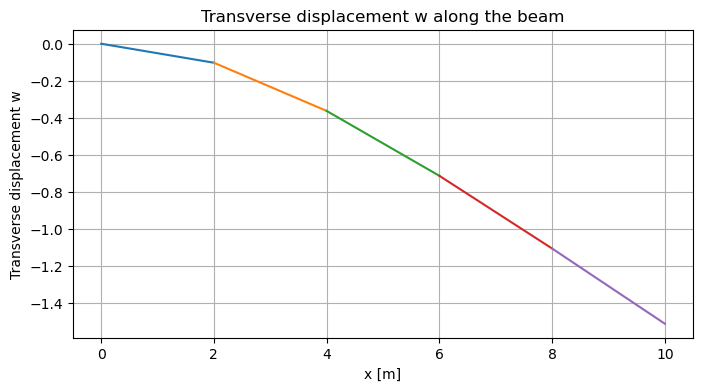

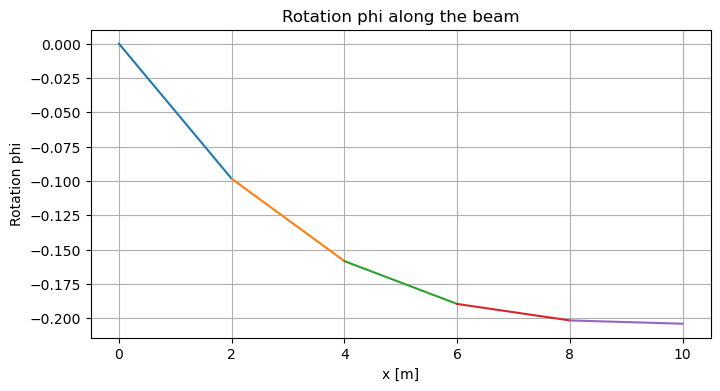

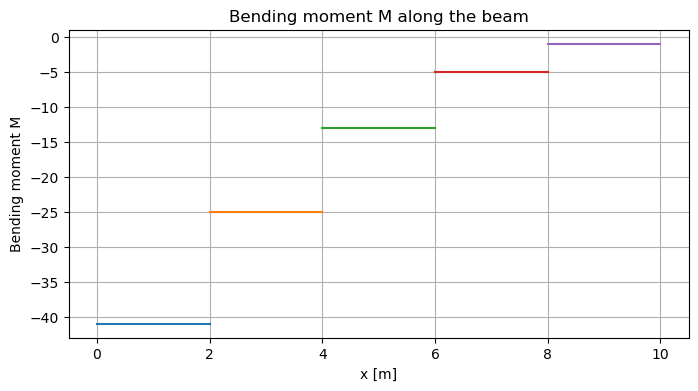

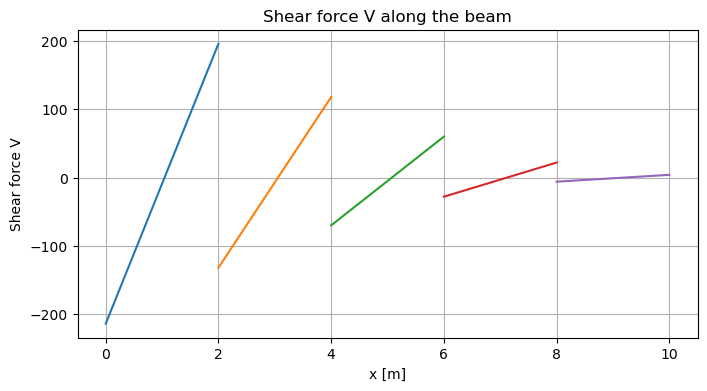

In [3]:
# individual plots
sol = FEM_linear_red # replace with desired solution to plot[FEM_linear, FEM_linear_red, FEM_Quadratic, FEM_Mixed, VEM_Quadratic, VEM_Mixed]
quantities = ['Transverse displacement w', 'Rotation phi', 'Bending moment M', 'Shear force V']
for i, label in enumerate(quantities):
    plt.figure(figsize=(8,4))
    for e, elem in enumerate(sol):
        x_vals = elem[0]
        y_vals = elem[i+1]  # +1 because x_vals is index 0
        plt.plot(x_vals, y_vals)
    plt.xlabel('x [m]')
    plt.ylabel(label)
    plt.title(f'{label} along the beam')
    plt.grid(True)
    plt.show()


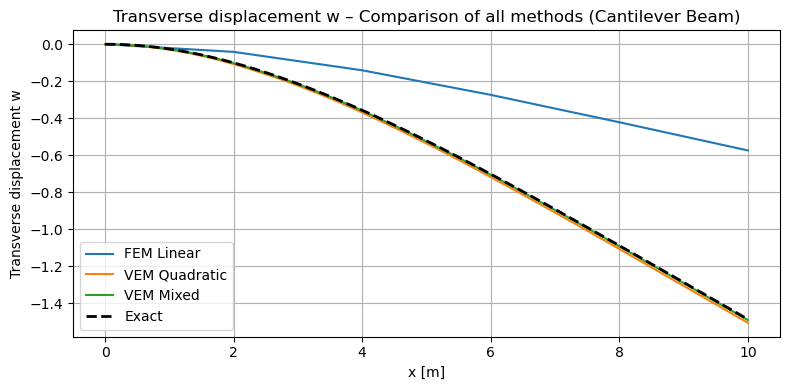

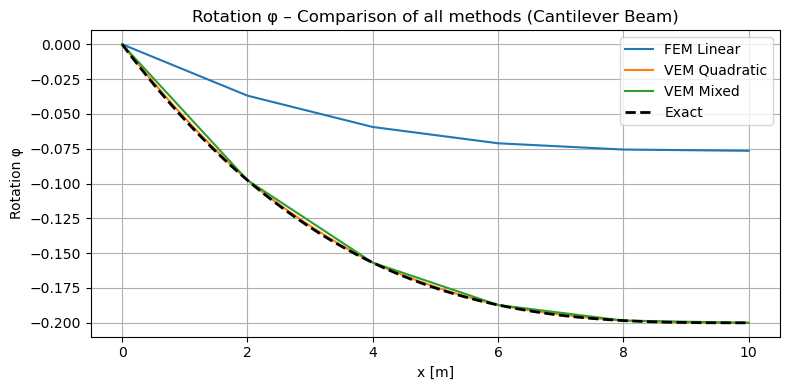

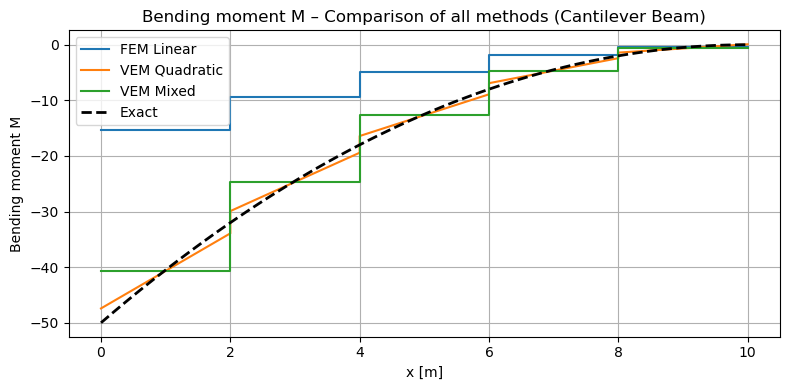

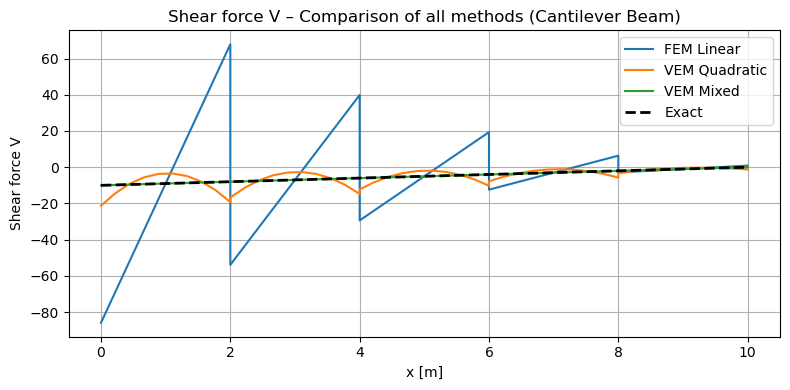

In [4]:
# All methods comparison

# -----------------------------
methods = {
   'FEM Linear'     : FEM_linear,
   #'FEM Linear Red' : FEM_linear_red,
   #'FEM Quadratic'  : FEM_Quadratic,
#'FEM Mixed'      : FEM_Mixed,
    'VEM Quadratic'  : VEM_Quadratic,
   'VEM Mixed'      : VEM_Mixed
} # uncomment desired methods to compare
# -----------------------------

quantities = ['Transverse displacement w', 'Rotation φ', 'Bending moment M', 'Shear force V']

# -----------------------------
# Exact solution
# -----------------------------




def exact_solution_func(x):
    V   = q_e*(L-x) + Fhat 
    M   = q_e/2*(L-x)**2+Fhat*(L-x) + Mhat  + m_e*(L-x) 
    phi = (1/EI)*(q_e/2*(L**2*x - L*x**2 + x**3/3) + Fhat*(L*x - x**2/2) + Mhat*x + m_e*(L*x - x**2/2))
    w = (1/EI)*(q_e/2*(L**2*x**2/2 - L*x**3/3 + x**4/12) + Fhat*(L*x**2/2 - x**3/6) + Mhat*x**2/2 + m_e*(L*x**2/2 - x**3/6))- (1/GA)*(q_e*(L*x - x**2/2) + Fhat*x )
    

    return np.array([w, phi, M, V])



x_exact = np.linspace(0, L, 100)
exact_vals = np.array([exact_solution_func(x) for x in x_exact])
exact_data = [exact_vals[:, i] for i in range(4)]

# -----------------------------
# Plotting
# -----------------------------
for i, label in enumerate(quantities):
    plt.figure(figsize=(8, 4))

    for method_name, method_data in methods.items():
        x_all, y_all = [], []
        for elem in method_data:
            x_all.extend(elem[0])
            y_all.extend(elem[i+1])

        plt.plot(x_all, y_all, label=method_name)

    # Exact solution
    plt.plot(x_exact, exact_data[i], 'k--', linewidth=2, label='Exact')

    plt.xlabel('x [m]')
    plt.ylabel(label)
    plt.title(f'{label} – Comparison of all methods (Cantilever Beam)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
